# Pipeline processing

This notebook demonstrates the continuum imaging and ICAL pipelines.

In [1]:
%matplotlib inline

import os
import sys

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.calibration.solvers import solve_gaintable
from arl.calibration.operations import apply_gaintable, create_gaintable_from_blockvisibility
from arl.data.data_models import Image
from arl.data.polarisation import PolarisationFrame
from arl.data.parameters import get_parameter
from arl.visibility.base import create_blockvisibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits, qa_image, copy_image, create_empty_image_like
from arl.visibility.iterators import vis_timeslice_iter
from arl.visibility.coalesce import convert_visibility_to_blockvisibility
from arl.util.testing_support import create_named_configuration, create_low_test_beam, \
    create_low_test_image_from_gleam, simulate_gaintable
from arl.imaging import create_image_from_visibility, advise_wide_field
from arl.imaging.imaging_context import invert_function, predict_function
from arl.pipelines.functions import ical

import logging

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

We create a graph to make the visibility. The parameter rmax determines the distance of the furthest antenna/stations used. All over parameters are determined from this number.

In [2]:
nfreqwin=5
ntimes=11
rmax=300.0
frequency=numpy.linspace(0.8e8,1.2e8,nfreqwin)
channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
times = numpy.linspace(-numpy.pi/3.0, numpy.pi/3.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

lowcore = create_named_configuration('LOWBD2-CORE', rmax=rmax)

block_vis = create_blockvisibility(lowcore, times, frequency=frequency, channel_bandwidth=channel_bandwidth,
                     weight=1.0, phasecentre=phasecentre,
                     polarisation_frame=PolarisationFrame("stokesI"))

create_blockvisibility: 11 rows, 0.015 GB


In [3]:
wprojection_planes=1
advice=advise_wide_field(block_vis, guard_band_image=4.0, delA=0.02,
                             wprojection_planes=wprojection_planes)

vis_slices = advice['vis_slices']
npixel=advice['npixels2']
cellsize=advice['cellsize']

advise_wide_field: Maximum wavelength 3.747 (meters)
advise_wide_field: Minimum wavelength 2.498 (meters)
advise_wide_field: Maximum baseline 229.0 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.107069 (rad) 6.135 (deg)
advise_wide_field: Image field of view 0.428275 (rad) 24.538 (deg)
advise_wide_field: Synthesized beam 0.004366 (rad) 0.250 (deg)
advise_wide_field: Cellsize 0.001455 (rad) 0.083 (deg)
advice_wide_field: Npixels per side = 294
advice_wide_field: Npixels (power of 2, 3) per side = 384
advice_wide_field: W sampling for full image = 0.3 (wavelengths)
advice_wide_field: W sampling for primary beam = 5.6 (wavelengths)
advice_wide_field: Time sampling for full image = 41.7 (s)
advice_wide_field: Time sampling for primary beam = 666.8 (s)
advice_wide_field: Frequency sampling for full image = 57881.5 (Hz)
advice_wide_field: Frequency sampling for primary beam = 926104.3 (Hz)
advice_wide_field: Number of planes in w sta

In [4]:
gleam_model = create_low_test_image_from_gleam(npixel=npixel, frequency=frequency,
    channel_bandwidth=channel_bandwidth, cellsize=cellsize, phasecentre=phasecentre, applybeam=True)

create_low_test_skycomponents_from_gleam: 7173 sources above flux limit 0.100
create_low_test_beam: primary beam is defined at 100.000 MHz
Quality assessment:
	Origin: qa_image
	Context: create_low_test_image_from_gleam
	Data:
		shape: (5, 1, 384, 384)
		max: 8.1181221868
		min: -0.03850248546
		rms: 0.0325136636258
		sum: 780.829143233
		medianabs: 0.0
		median: 0.0



In [5]:
predicted_vis = predict_function(block_vis, gleam_model, vis_slices=51, context='wstack')
block_vis=convert_visibility_to_blockvisibility(predicted_vis)
gt = create_gaintable_from_blockvisibility(block_vis)
gt = simulate_gaintable(gt, phase_error=1.0)
blockvis = apply_gaintable(block_vis, gt)

In [6]:
model = create_image_from_visibility(block_vis, npixel=npixel, frequency=[numpy.average(frequency)], nchan=1,
    channel_bandwidth=[numpy.sum(channel_bandwidth)], cellsize=cellsize, phasecentre=phasecentre)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 30., -60.)>, starting frequency 100000000.0 Hz, and bandwidth [ 50000000.] Hz
create_image_from_visibility: uvmax = 101.803178 wavelengths
create_image_from_visibility: Critical cellsize = 0.004911 radians, 0.281405 degrees
create_image_from_visibility: Cellsize          = 0.001455 radians, 0.083383 degrees


In [7]:
dirty, sumwt = invert_function(predicted_vis, model, vis_slices=vis_slices, dopsf=False, context='wstack')

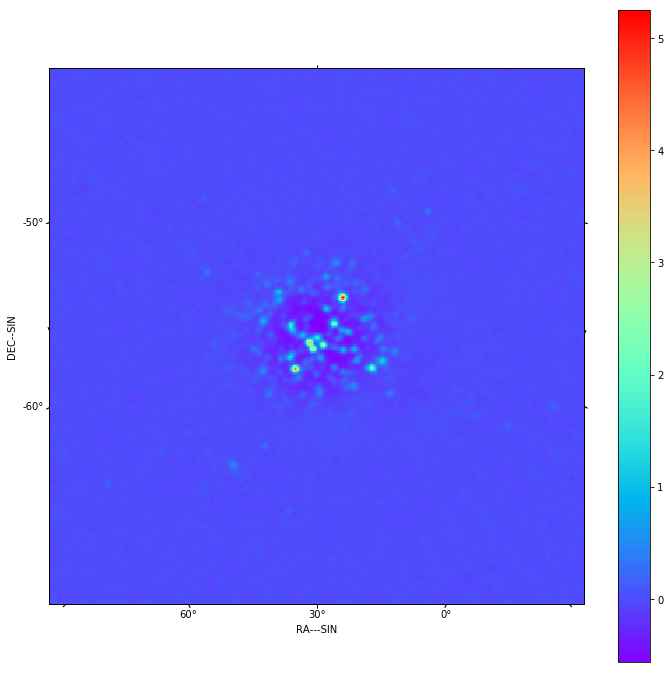

In [8]:
show_image(dirty)
plt.show()

In [9]:
deconvolved, residual, restored = ical(block_vis=blockvis, model=model, vis_slices=vis_slices, timeslice='auto',
                                                  algorithm='hogbom', niter=1000, fractional_threshold=0.1, threshold=0.1,
                                                  context='wstack', nmajor=5, gain=0.1, first_selfcal=1,
                                                  global_solution=False)

ical: Performing 5 major cycles
Maximum in residual image is 1.902667
ical: Start of major cycle 0 of 5
deconvolve_cube: Hogbom clean of each polarisation and channel separately
deconvolve_cube: Processing pol 0, channel 0
hogbom: Max abs in dirty image = 1.902667
hogbom: Start of minor cycle
hogbom: This minor cycle will stop at 1000 iterations or peak < 0.190266686618
hogbom: Max abs in dirty Image = 1.902667
hogbom: Minor cycle 0, peak 1.90266686618 at [219, 210]
hogbom: Minor cycle 100, peak 0.391506326244 at [200, 173]
hogbom: Minor cycle 200, peak 0.257289670233 at [234, 198]
hogbom: Stopped at iteration 255, peak 0.189260105138 at [217, 164]
hogbom: End of minor cycle
Maximum in residual image is 0.223908529298
ical: End of major cycle
ical: Start of major cycle 1 of 5
deconvolve_cube: Hogbom clean of each polarisation and channel separately
deconvolve_cube: Processing pol 0, channel 0
hogbom: Max abs in dirty image = 0.223909
hogbom: Start of minor cycle
hogbom: This minor cycl

Quality assessment:
	Origin: qa_image
	Context: Clean image
	Data:
		shape: (1, 1, 384, 384)
		max: 4.42140919243
		min: -0.0487304034253
		rms: 0.0246394090869
		sum: 72.4051756387
		medianabs: 0.0
		median: 0.0



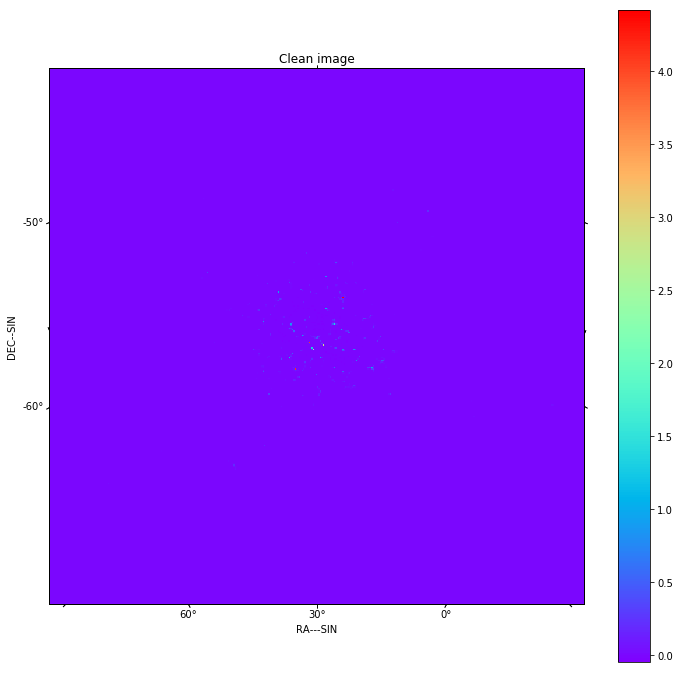

Quality assessment:
	Origin: qa_image
	Context: Residual clean image
	Data:
		shape: (1, 1, 384, 384)
		max: 0.114387499385
		min: -0.111742665109
		rms: 0.0197285231409
		sum: 7.91264528442
		medianabs: 0.0057323189799
		median: -0.000626771904004



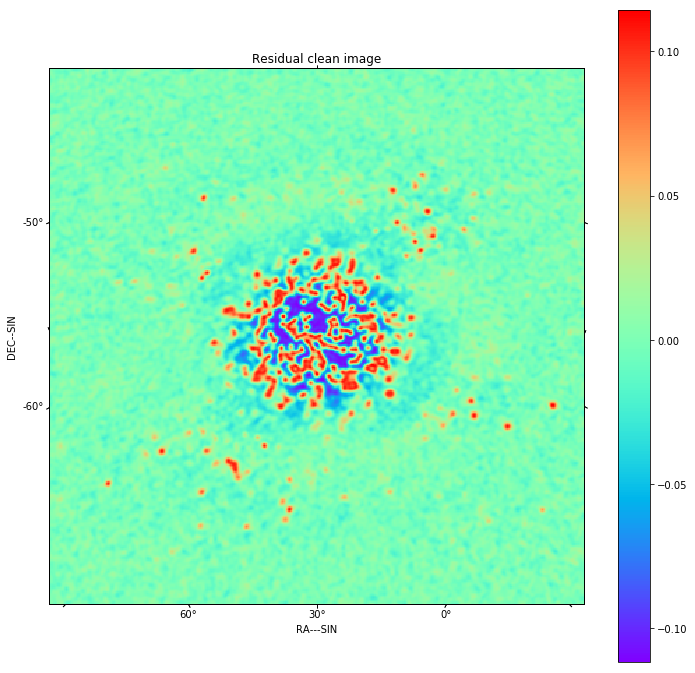

Quality assessment:
	Origin: qa_image
	Context: Restored clean image
	Data:
		shape: (1, 1, 384, 384)
		max: 5.41273121981
		min: -0.228324418058
		rms: 0.112255753416
		sum: 1488.25685367
		medianabs: 0.00574941168815
		median: -0.000465235492954



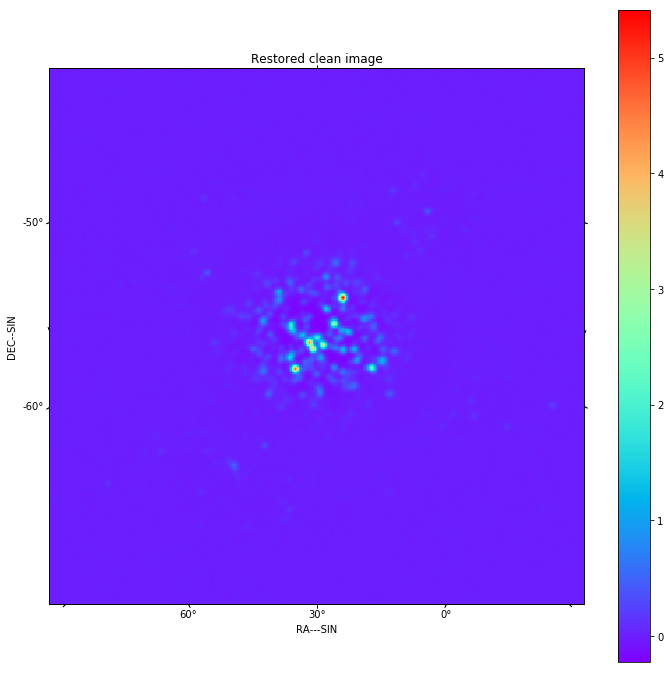

In [10]:
f = show_image(deconvolved, title='Clean image')
print(qa_image(deconvolved, context='Clean image'))
plt.show()

f = show_image(residual, title='Residual clean image')
print(qa_image(residual, context='Residual clean image'))
plt.show()
export_image_to_fits(residual, '%s/imaging-dask_ical_residual.fits'
                     % (results_dir))

f = show_image(restored, title='Restored clean image')
print(qa_image(restored, context='Restored clean image'))
plt.show()
export_image_to_fits(restored, '%s/imaging-dask_ical_restored.fits'
                     % (results_dir))